# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World


## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [54]:
# define percepts (current location is NW corner and it is dirty)
#bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
#simple_randomized_agent(bumpers, dirty)

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`. 

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned




Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: east
step 1 - action: suck
step 2 - action: east
step 3 - action: north
step 4 - action: east
step 5 - action: west
step 6 - action: north
step 7 - action: east
step 8 - action: south
step 9 - action: east
step 10 - action: west
step 11 - action: west
step 12 - action: south
step 13 - action: suck
step 14 - action: west
step 15 - action: west
step 16 - action: west
step 17 - action: south
step 18 - action: suck
step 19 - action: south


3

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. Use the same environmnt for all your agent implementations in the tasks below.

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [2]:
# Your code and description goes here
#https://thispointer.com/python-create-boolean-numpy-array-with-all-true-or-all-false-or-random-boolean-values/
#Create a boolean 2d randomized array

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

#this will create a completely random room
def randomize_room(num = 5):
    rng = np.random.default_rng()
    p = .2
    sample_arr = [True, False]
    bool_arr = np.random.choice(sample_arr, size=(num,num), p = [0.8,.2])
    return bool_arr

#this function shows the room and where the robot is
def show_room(room, pos, fontsize = 24):
    """display room and robot

    Parameters
    ----------
    room : bool 2d array
        Dirt locations in the room.
    pos : list of 2 int values
        x and y location of the robot.
    fint_size : int
        size of the robot symbol.
    """

    cmap = colors.ListedColormap(['white', 'gray'])

    room = np.copy(room)
    room = room.astype(np.int64)

    fig, ax = plt.subplots()
    ax.imshow(room, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N+1)), cmap.N))

    plt.text(pos[1], pos[0], u"\u2B24", fontsize = fontsize,
                 horizontalalignment = 'center', verticalalignment = 'center')

    plt.show()



def print_matrix(input):
    print('\n'.join([''.join(['{:4}'.format(item) for item in row])
        for row in input]))

def simulation_environment(agent, max_steps, num = 5, verbose = True):
    from random import seed
    from random import randint
    bool_arr = randomize_room(num)
    num_cleaned = 0
    actions_spent = 0

    x = randint(0,num - 1)
    y = randint(0,num - 1)
    agent_position = (x,y)

    for i in range(max_steps):
        dirty = bool_arr[x][y]

        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        #setting boundaries so robot cannot go past
        #south bumper activated
        if x >= num-1:
            bumpers = {"north" : False, "south" : True, "west" : False, "east" : False}

        #east bumper activated
        if y >= num-1:
            bumpers = {"north" : False, "south" : False, "west" : False, "east" : True}

        #north bumper activated
        if x <= 0:
            bumpers = {"north" : True, "south" : False, "west" : False, "east" : False}

        #west bumper activated
        if y <= 0:
            bumpers = {"north" : False, "south" : False, "west" : True, "east" : False}

        #SOUTH and EAST bumper activated
        if x >= num-1 and y>= num-1:
            bumpers = {"north" : False, "south" : True, "west" : False, "east" : True}

        #SOUTH and WEST bumper activated
        if x >= num-1 and y<= 0:
            bumpers = {"north" : False, "south" : True, "west" : True, "east" : False}

        #NORTH and EAST bumper activated
        if x <= 0 and y >= num-1:
            bumpers = {"north" : True, "south" : False, "west" : False, "east" : True}

        #NORTH and WEST bumper activated
        if x <= 0 and y <= 0:
            bumpers = {"north" : True, "south" : False, "west" : True, "east" : False}

        #moving the robot
        action = agent(bumpers, dirty)

        if verbose == False: print("step", i, "- action:", action)

        if (action == "west") and not bumpers.get("west") == True:
            y -= 1
        if(action == "north") and not bumpers.get("north") == True:
            x -= 1
        if(action == "south") and not bumpers.get("south") == True:
            x += 1
        if(action == "east") and not bumpers.get("east") == True:
            y += 1


        #if (action == "suck" and bool_arr[x][y] == False):
        if (action == "suck"):
            bool_arr[x][y] = 1

        agent_position = (x,y)
        if(verbose == False):
            show_room(bool_arr,agent_position,10)

        #adds up the steps and actions used
        actions_spent +=1
        #ends for loop if everything is cleared
        if(bool_arr.all() == True):
            return actions_spent
    return actions_spent



In [3]:
simulation_environment(simple_randomized_agent, max_steps = 10000,num=5, verbose=True)

329

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [8]:
# Your code and description goes here

import numpy as np
#actions = ["north", "east", "west", "south", "suck"]
def simple_reflex_agent(bumpers, dirtyreflex):
    actions_simple = ["north", "east", "west", "south", "suck"]
    if dirtyreflex == 0:
        actions_simple = "suck"
        return actions_simple

        #south bumper activated
    if bumpers == {"north" : False, "south" : True, "west" : False, "east" : False}:
        actions_simple = ["north", "east", "west"]

        #east bumper activated
    if bumpers == {"north" : False, "south" : False, "west" : False, "east" : True}:
        actions_simple = ["north", "west", "south"]

        #north bumper activated
    if bumpers == {"north" : True, "south" : False, "west" : False, "east" : False}:
        actions_simple = ["east", "west", "south"]

        #west bumper activated
    if bumpers == {"north" : False, "south" : False, "west" : True, "east" : False}:
        actions_simple = ["north", "east", "south"]

        #SOUTH and EAST bumper activated
    if bumpers == {"north" : False, "south" : True, "west" : False, "east" : True}:
        actions_simple = ["north", "west"]

        #SOUTH and WEST bumper activated
    if bumpers == {"north" : False, "south" : True, "west" : True, "east" : False}:
        actions_simple = ["north", "east"]

        #NORTH and EAST bumper activated
    if bumpers == {"north" : True, "south" : False, "west" : False, "east" : True}:
        actions_simple = ["west", "south"]

        #NORTH and WEST bumper activated
    if bumpers == {"north" : True, "south" : False, "west" : True, "east" : False}:
        actions_simple = ["east", "south"]

    return np.random.choice(actions_simple)

In [88]:
simulation_environment(simple_reflex_agent, num= 10, max_steps = 10000)

1256

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb))

In [128]:
# Your short description of the state and your implementation goes here
#The agent state is where the robot is located and that can be found through the bumpers and where the robot perceives itself to be relative to the room. This can be implemented by first identifying where the robot is, the robot can automatically move north when it is placed and either when it reaches the north side of the room or if its already on the north side, the robot will automatically move west until it reaches the west wall. If it is already at the north and west corner, it will not move north or west.

#Once the robot is at the NW corner, the robot will move south until it hits the south wall, then it will move east one step, and go up north until it hits the north wall. After it hits the north wall, it will move east one step and go down south until it hits the south wall. This continual process will loop until the robot cannot move east. That means ever spot has been traversed and appropriately cleaned.

In [38]:
# Your code goes here
class Agent:
#
    def __init__(self, name = "An Agent"):
        self.name = name
        self.position_x = 0
        self.position_y = 0
        self.NW = False
        self.SW = True
        self.touchedN = False
        self.touchedS = False
        self.exitedSW = False
        self.middleN = False
        self.middleS = False
        self.SE_corner = False
        self.NE_corner = False

    def act(self, agent_bumpers, agent_dirty):
        corner = 0
        x_y_position = (self.position_y, self.position_x)

        #if agent is ever on a dirty spot, it will suck
        if agent_dirty == 0:
                return "suck"

        #This is to find the NW corner
        if self.NW == False:
            if agent_bumpers == {"north" : False, "south" : False, "west" : True, "east" : False}:
                return "north"
            if agent_bumpers == {"north" : True, "south" : False, "west" : False, "east" : False}:
                return "west"
            if agent_bumpers == {"north" : True, "south" : False, "west" : False, "east" : True}:
                return "west"
            if agent_bumpers == {"north" : True, "south" : False, "west" : True, "east" : False}:
                self.NW = True
            else: return "north"

        #once the corner is found
        if agent_bumpers == {"north" : True, "south" : False, "west" : True, "east" : False}:
            self.position_x = 0
            self.position_y = 0
            self.position_x += 1
            #continues to next function
            self.NW = True
            x_y_position = (self.position_y, self.position_x)
            #print(x_y_position)
            return "south"

        #on NW corner
        if self.NW == True:
            #on West wall
            if agent_bumpers == {"north" : False, "south" : False, "west" : True, "east" : False}:
                return "south"

            #on SW corner
            if agent_bumpers == {"north" : False, "south" : True, "west" : True, "east" : False}:
                self.SW = False
                self.exitedSW = True
                self.touchedS = True
                return "east"


        if  self.SW == False:
            #on South wall
            if agent_bumpers == {"north" : False, "south" : True, "west" : False, "east" : False} \
                    and self.touchedS == False and self.exitedSW:
                self.touchedS = True
                return "east"

            #South Wall after moving East
            if agent_bumpers == {"north" : False, "south" : True, "west" : False, "east" : False} \
                    and self.touchedS == True:
                self.touchedS = False
                self.middleS = True
                self.middleN = False
                return "north"

            #on North wall
            if agent_bumpers == {"north" : True, "south" : False, "west" : False, "east" : False} \
                    and self.touchedN == False:
                self.touchedN = True
                return "east"

            #North Wall
            if agent_bumpers == {"north" : True, "south" : False, "west" : False, "east" : False} \
                    and self.touchedN == True:
                self.touchedN = False
                self.middleN = True
                self.middleS = False
                return "south"

            #on NE Corner
            if agent_bumpers == {"north" : True, "south" : False, "west" : False, "east" : True}:
                self.NE_corner = True
                return "south"

            #on SE Corner
            if agent_bumpers == {"north" : False, "south" : True, "west" : False, "east" : True}:
                self.SE_corner = True
                return "north"

            #on East wall from NE corner
            if agent_bumpers == {"north" : False, "south" : False, "west" : False, "east" : True} \
                    and self.NE_corner:
                return "south"

            #on East wall from SE corner
            if agent_bumpers == {"north" : False, "south" : False, "west" : False, "east" : True} \
                    and self.SE_corner:
                return "north"


        #continue going down
        if self.middleN:
            return "south"

        #continue going up
        if self.middleS == True:
                return "north"


In [39]:
agent1 = Agent(name = "Agent 1")
simulation_environment(agent1.act, num=5, max_steps= 200, verbose=True)


26

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents. 
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/charts_and_tables.ipynb))

In [103]:
# Your code goes here
import numpy as np
import pandas as pd
agent_1_5x5 = []
agent_2_5x5 = []
agent_3_5x5 = []

agent_1_10x10 = []
agent_2_10x10 = []
agent_3_10x10 = []

agent_1_100x100 = []
agent_2_100x100 = []
agent_3_100x100 = []

for i in range(100):
    #append agents to dataframe
    agent_1_5x5.append(simulation_environment(simple_randomized_agent,num=5, max_steps = 1000))
    agent_2_5x5.append(simulation_environment(simple_reflex_agent, num=5, max_steps = 1000))
    model_agent = Agent(name = "Agent 1")
    agent_3_5x5.append(simulation_environment(model_agent.act, num=5, max_steps=200))

for i in range(100):
    #append agents to dataframe
    agent_1_10x10.append(simulation_environment(simple_randomized_agent,num=10, max_steps = 10000))
    agent_2_10x10.append(simulation_environment(simple_reflex_agent, num=10, max_steps = 10000))
    model_agent_10 = Agent(name = "Agent 2")
    agent_3_10x10.append(simulation_environment(model_agent.act, num=10, max_steps=2000))

# for i in range(100):
#     #append agents to dataframe
#     agent_1_100x100.append(simulation_environment(simple_randomized_agent,num=100, max_steps = 50000))
#     agent_2_100x100.append(simulation_environment(simple_reflex_agent, num=100, max_steps = 50000))
#     model_agent_100 = Agent(name = "Agent 3")
#     agent_3_100x100.append(simulation_environment(model_agent.act, num=100, max_steps=10000))

def Average(lst):
    return sum(lst) / len(lst)

#print (Average(agent_1_5x5))
#print (Average(agent_2_5x5))
#print (Average(agent_3_5x5))

runtime_5 = {
    "Simple Randomized Agent (5x5)" : np.add(100,agent_1_5x5),
    "Simple Reflex Agent (5x5)" : np.add(100, agent_2_5x5),
    "Model-Based Agent (5x5)" : np.add(100, agent_3_5x5)
}

runtime_10 = {
    "Simple Randomized Agent (10x10)" : np.add(100,agent_1_10x10),
    "Simple Reflex Agent (10x10)" : np.add(100, agent_2_10x10),
    "Model-Based Agent (10x10)" : np.add(100, agent_3_10x10)
}
# runtime_100 = {
#     "Simple Randomized Agent (100x100)" : np.add(100,agent_1_100x100),
#     "Simple Reflex Agent (100x100)" : np.add(100, agent_2_100x100),
#     "Model-Based Agent (100x100)" : np.add(100, agent_3_100x100)
# }
# show data as a data frame using pandas
df = pd.DataFrame(runtime_5)
#df = pd.DataFrame(runtime_10)
# df = pd.DataFrame(runtime_100)
df

,Simple Randomized Agent (5x5),Simple Reflex Agent (5x5),Model-Based Agent (5x5)
0,521,178,132
1,467,167,127
2,828,329,116
3,911,189,118
4,394,155,130
...,...,...,...
95,550,139,129
96,351,132,123
97,880,238,126
98,764,490,123


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | 423.06           | 125.4               | 34                       |
| 10x10   | 3,009.27         | 1,174.72            | 196.55                   |
| 100x100 | 836,080.82       | 316,387.21          | 19921.69                 |

Add charts to compare the performance of the different agents.

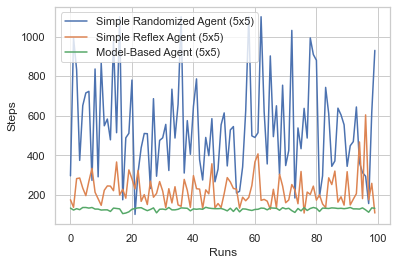

In [14]:
# Your graphs and discussion of the results goes here
import matplotlib.pyplot as plt

# add a grid to the plots
import seaborn as sns
sns.set(style="whitegrid")

agent_1_5x5 = []
agent_2_5x5 = []
agent_3_5x5 = []

for i in range(100):
    #append agents to dataframe
    agent_1_5x5.append(simulation_environment(simple_randomized_agent,num=5, max_steps = 1000))
    agent_2_5x5.append(simulation_environment(simple_reflex_agent, num=5, max_steps = 1000))
    model_agent = Agent(name = "Agent 1")
    agent_3_5x5.append(simulation_environment(model_agent.act, num=5, max_steps=200))

runtime_5 = {
    "Simple Randomized Agent (5x5)" : np.add(100,agent_1_5x5),
    "Simple Reflex Agent (5x5)" : np.add(100, agent_2_5x5),
    "Model-Based Agent (5x5)" : np.add(100, agent_3_5x5)
}

x = range(100)
plt.plot(x, runtime_5["Simple Randomized Agent (5x5)"], label = "Simple Randomized Agent (5x5)")
plt.plot(x, runtime_5["Simple Reflex Agent (5x5)"], label = "Simple Reflex Agent (5x5)")
plt.plot(x, runtime_5["Model-Based Agent (5x5)"], label = "Model-Based Agent (5x5)")
plt.xlabel("Runs")
plt.ylabel("Steps")
plt.legend()
plt.show()


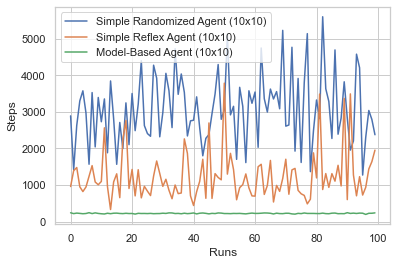

In [29]:
sns.set(style="whitegrid")

agent_1_10x10 = []
agent_2_10x10 = []
agent_3_10x10 = []

for i in range(100):
    #append agents to dataframe
    agent_1_10x10.append(simulation_environment(simple_randomized_agent,num=10, max_steps = 10000))
    agent_2_10x10.append(simulation_environment(simple_reflex_agent, num=10, max_steps = 10000))
    model_agent = Agent(name = "Agent 1")
    agent_3_10x10.append(simulation_environment(model_agent.act, num=10, max_steps=200))

runtime_10 = {
    "Simple Randomized Agent (10x10)" : np.add(100,agent_1_10x10),
    "Simple Reflex Agent (10x10)" : np.add(100, agent_2_10x10),
    "Model-Based Agent (10x10)" : np.add(100, agent_3_10x10)
}

x = range(100)
plt.plot(x, runtime_10["Simple Randomized Agent (10x10)"], label = "Simple Randomized Agent (10x10)")
plt.plot(x, runtime_10["Simple Reflex Agent (10x10)"], label = "Simple Reflex Agent (10x10)")
plt.plot(x, runtime_10["Model-Based Agent (10x10)"], label = "Model-Based Agent (10x10)")
plt.xlabel("Runs")
plt.ylabel("Steps")
plt.legend()
plt.show()

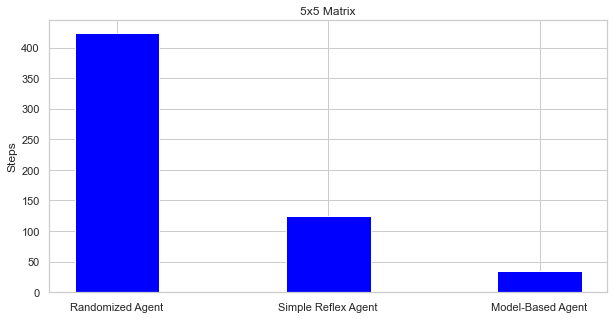

In [23]:
data = {"Randomized Agent" : 423.06, "Simple Reflex Agent" : 125.4, "Model-Based Agent": 34}
keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color ='blue',
        width = 0.4)


plt.ylabel("Steps")
plt.title("5x5 Matrix")
plt.show()

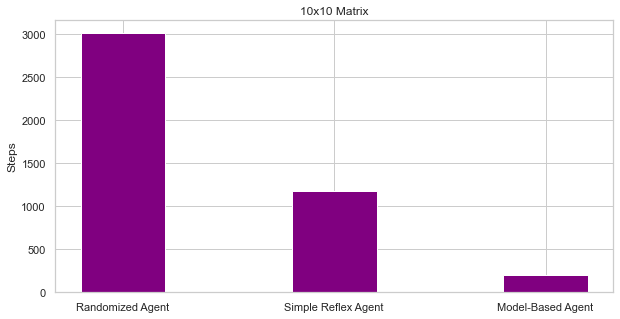

In [24]:
data = {"Randomized Agent" : 3009.27, "Simple Reflex Agent" : 1174.72, "Model-Based Agent": 196.55}

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color ='purple',
        width = 0.4)


plt.ylabel("Steps")
plt.title("10x10 Matrix")
plt.show()

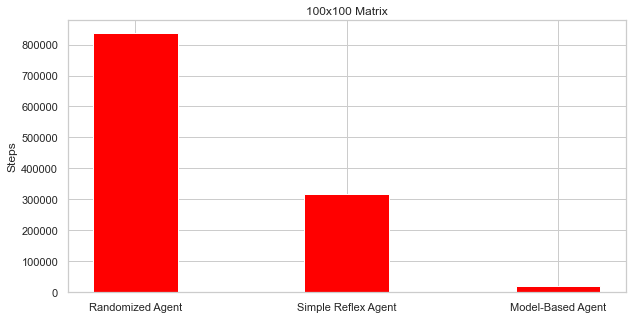

In [25]:
data = {"Randomized Agent" : 836080.82, "Simple Reflex Agent" : 316387.21, "Model-Based Agent": 19921.69}

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color ='red',
        width = 0.4)


plt.ylabel("Steps")
plt.title("100x100 Matrix")
plt.show()

## Task 5: Robustness of the agent implementations [10 Points] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [30]:
# Answer goes here
# 1. For all robots, they would go either go out of bounds or not go beyond an
# area in which they are confined to because the bumpers are based on the
# locations of the walls which are simply numbers I assign. If the bumpers are
# already configured in the environment, the robot would perform as normal.
# 2. For the random robot and the reflex robot, they would not be able to enter the
# other room or hallway because they are confined into the
# rectangular shape in the simulation environment. If the environment is
# adjusted accordingly, the randomized robot would take much longer to
# enter the other room and accordingly increase the steps taken significantly.
# The reflex robot would take similarly long as well, because the
# randomized actions could cause it to enter the hallway but then go back to the
# room from which it came from, increasing the steps significantly.
# For the model-based robot, it would not enter the hallway unless the wall was
# on the NE or SE corner.
# 3. For the random robot and the reflex robot, the time to clean the room would
# take slightly longer but the steps would not increase significantly.
# The robots would pretty effectively move into a different direction once the
# robot's bumpers are triggered. For the model-based robot,
# if the room contains obstacles, the robot will not fully clean the room and
# will eventually just stop in the SE corner. The other edge case
# is if there is two obstacles or one obstacle and the east or south wall,
# where the robot believes it to be in the SE corner and
# simply performs no actions after that.

## Graduate student advanced task: Obstacles [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [12]:
# Your code and discussion goes here
#After hitting an obstacle while going north or south, the robot should continue
# moving east until it reaches the east wall.
#Then the robot instead of ending in the SE corner, should go west in the
#north-south movement until it reaches the West wall and stop at the NW or SW corner.

## More advanced implementation tasks

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actualy depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currebntly clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [13]:
# Your ideas/code
